In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy
import scipy.stats as stats

df = pd.read_excel('/content/region roles.xlsx')

# ***1. Обработка данных***

In [ ]:
# Теперь узнаем в каких столбцах мы имеем пропуски и их количество.
df.isnull().sum()

Unnamed: 0                      0
id                              0
premium                         0
name                            0
department                  64393
has_test                        0
response_letter_required        0
area                            0
salary                      32066
type                            0
address                     29338
response_url                69655
sort_point_distance         69656
published_at                    0
created_at                      0
archived                        0
insider_interview           69134
url                             0
alternate_url                   0
relations                       0
employer                        0
snippet                         0
contacts                    34542
schedule                        0
working_days                    0
working_time_intervals          0
working_time_modes              0
accept_temporary                0
description                     0
experience    

***В результате проверки имеем колонки с большим числом пропусков department, address, response_url, sort_point_distance, insider_interview, contacts, immediate_redirect_url и salary, в колонке salary число пропусков сократиться после фильтрации вакансий и удаления всех оставшихся пропусков, данную колонку удалить не можем, т.к. в ней  имеется интересующая нас величина заработной платы.*** 
***Пропуски уберем после фильтрации данных по интересующим нас вакансиям.***

*Так же сразу удаляем колонки которые не несут для нашего исследования ни какой  полезной информации.*

In [ ]:
df.drop(['Unnamed: 0', 'id', 'premium', 'department', 'has_test', 'response_letter_required', 'area', 'type',
	'published_at', 'created_at', 'archived', 'insider_interview', 'url', 'alternate_url', 'relations',
	'snippet', 'schedule', 'working_days', 'working_time_intervals', 'working_time_modes', 'accept_temporary',
	'description', 'address', 'response_url', 'sort_point_distance', 'contacts', 'immediate_redirect_url', 'employer'], axis=1, inplace=True)

*Проверяем что получили после удаления колонок*

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69656 entries, 0 to 69655
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             69656 non-null  object
 1   salary           37590 non-null  object
 2   experience       69656 non-null  object
 3   key_skills       69656 non-null  object
 4   specializations  69656 non-null  object
 5   region           69656 non-null  object
dtypes: object(6)
memory usage: 3.2+ MB


### ***Приведение датасета в рабочую форму***

*Нужно убрать пропуски в salary, выделить ключевыу специализации и навыки, так же смениь название столбцов на русские. Делаем распаковку списка со словарем и переводим все в удобный формат для работы*


In [ ]:
def data_cleaning(text):
	try:
		return json.loads(text.replace('"', '').replace("'", '"'))
	except:
		return []
df['new_specializations'] = df['specializations'].apply(data_cleaning)
df['key_skills_json'] = df['key_skills'].apply(data_cleaning)

def get_values(json):
	try:
		out = []
		if len(json)>0:
			for i in json:
				out.append(i['name'])
		return out
	except:
		return []
df['key_skills'] = df['key_skills_json'].apply(get_values)
df.drop(['key_skills_json'], axis=1, inplace=True)

def return_index(data):
	try:
		return data[0]['name']
	except:
		return[]
df['specializations'] = df['new_specializations'].apply(return_index)
df.drop(['new_specializations'], axis=1, inplace=True)

# Отчистка столбца с опытом работы
df['experience'][1].replace("{", '').replace("}", '').split(',')
df['experience'][1].replace("{", '').replace("}", '').split(',')[-1][9:]
df['experience'][1].replace("'", ' ').replace("'",' ')[-1][9:]

def experience_from(experience):
  if pd.isna(experience): 
    clean_experience = np.nan
  else:
    clean_experience = experience.replace("{", '').replace("}", '').split(',')[-1][9:]
    if clean_experience == 'None':
    	clean_experience = np.nan
  return clean_experience
df['experience'] = df.experience.apply(experience_from)


*Делаем отбор вакансий по специализации Программирование, Разработка это позволит сократить количество вакансий, т.к. нам нужны вакансии связанные с IT сферой, а не с продажами, сферой услуг и т.д.*
*Затем чистим колнку с зарплатой, оставим только минимальную зарплату.*

In [ ]:
def dev(data):
	return 'Программирование, Разработка' in data

filter = df['specializations'].apply(dev)
df = df[filter]

df.salary.isna().sum()
df['salary'][1].replace("{", '').replace("}", '').split(',')
df['salary'][1].replace("{", '').replace("}", '').split(',')[0][8:]

def clear_salary(salary):
	if pd.isna(salary):
		clean_salary = np.nan
	else:
		clean_salary = salary.replace("{", '').replace("}", '').split(',')[0][8:]
		if clean_salary == 'None':
			clean_salary = np.nan
	return clean_salary

df['min_salary'] = df.salary.apply(clear_salary)
df['salary'] = pd.to_numeric(df['min_salary'])
df.drop(['min_salary'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

*Удаляем все пропуски в таблице*.

In [ ]:
df = df.dropna(axis=0, how='any')

*Приводим колонку зарплат к числовому тип*

In [ ]:
df['salary'] = df['salary'].astype('Int64')
df['salary']


1         25000
33        57500
35        50000
56        50000
108       50000
          ...  
69645    100000
69646     70000
69647    130000
69648     20000
69652    130000
Name: salary, Length: 8389, dtype: Int64

## *Внесем изменения в колонку опыт работы*

In [ ]:
work_experience_formatting = {
    "'Нет опыта'" : 'Нет опыта',
    "'От 1 года до 3 лет'" :'От 1 до 3 лет',
    "'От 3 до 6 лет'" : 'От 3 до 6 лет', 
    "'Более 6 лет'" : 'Более 6 лет'}

df['experience'] = df['experience'].map(work_experience_formatting).fillna(df['experience'])
df['experience']

1        От 1 до 3 лет
33       От 1 до 3 лет
35       От 1 до 3 лет
56       От 1 до 3 лет
108      От 1 до 3 лет
             ...      
69645    От 3 до 6 лет
69646    От 1 до 3 лет
69647    От 3 до 6 лет
69648    От 3 до 6 лет
69652    От 1 до 3 лет
Name: experience, Length: 8389, dtype: object

## *Поменяем имена колонок*

In [ ]:
df = df.rename(columns={'name' : 'Вакансии', 'salary' : 'Зарплата', 'experience' : 'Опыт работы', 'key_skills' : 'Навыки', 'specializations' : 'Специализация', 'region' : 'Регион'})

*Упорядочим индексы строк по возрастанию и уберем пустые списки в колонке: "Навыки"*

In [ ]:
df = df.reset_index(drop=True)

# ***2. Определение типа данных***

*Проверяем колнки на тип данных*

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389 entries, 0 to 8388
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Вакансии       8389 non-null   object
 1   Зарплата       8389 non-null   Int64 
 2   Опыт работы    8389 non-null   object
 3   Навыки         8389 non-null   object
 4   Специализация  8389 non-null   object
 5   Регион         8389 non-null   object
dtypes: Int64(1), object(5)
memory usage: 401.6+ KB


***Типы данных для дата сета:***

*name(наименование вакансий) - категориальный тип*

*salary(заработная плата) - количественный тип*

*experience(опыт работы) -  категориальный тип*

*key_skills(ключевые навыки) - категориальный тип*

*specializations(специализация) - категориальный тип*

*region(регион в котором размещена вакансия) - категориальный тип*

# ***3. Визуализация данных и корреляция между ними***

## ***Kоличество вакансий в регионах***

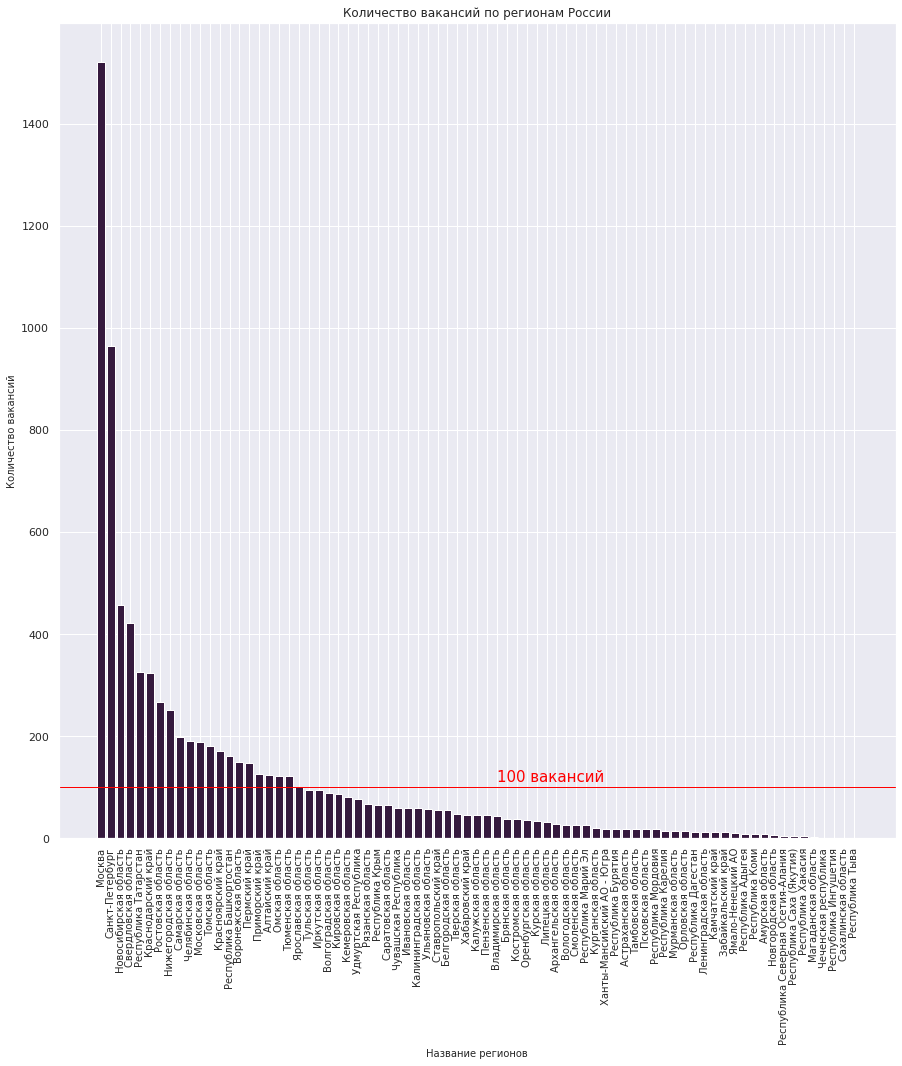

In [ ]:
region_vac = df['Регион'].value_counts()
fig = plt.figure(figsize = (15, 15))
plt.bar(region_vac.index, region_vac)
plt.title('Количество вакансий по регионам России')
plt.ylabel('Количество вакансий', fontsize=10)
plt.xlabel('Название регионов', fontsize=10)
plt.xticks(fontsize = 10, rotation = 90) # размер шрифта и угол наколна наименования вакансий
plt.axhline(y = 100, color = 'red', linewidth=1)
plt.text(x=40, y=110, s = '100 вакансий', size=15, color='red')
plt.show()

*Данная диаграмма показывает, что с большим отрывом по вакансиям лидирует Москва.*

## ***Круговая диаграмма с рапределением вакансий к опыту работы***

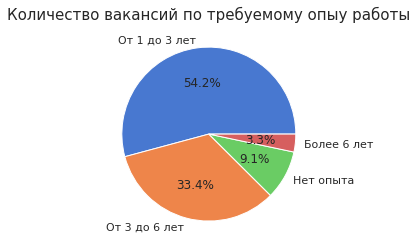

In [ ]:
exp_count = df['Опыт работы'].value_counts()
colors = sns.color_palette("muted")
plt.pie(exp_count, labels=exp_count.index, autopct='%1.1f%%', colors=colors)
plt.title(label = 'Количество вакансий по требуемому опыу работы', fontsize = 15)
plt.show()

## ***График требуемых навыков***

In [ ]:
df['Навыки'].explode().value_counts()[:10]

Git                    1594
1С программирование    1272
JavaScript             1109
SQL                    1069
1С: Предприятие 8       866
PHP                     838
ООП                     748
MySQL                   740
PostgreSQL              702
Linux                   682
Name: Навыки, dtype: int64

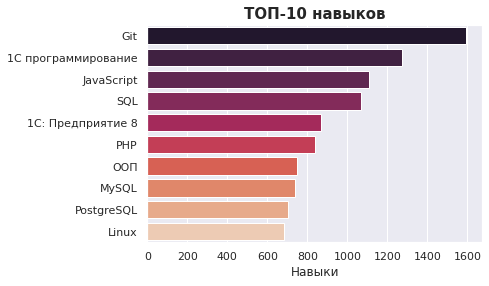

In [ ]:
skill = df['Навыки'].explode().value_counts()[:10]

sns.set_theme(style="darkgrid", palette="rocket")
x = skill.index[:10]
y1 = skill[:10]


sns.barplot(y=x, x=y1, palette="rocket")
plt.title('ТОП-10 навыков',fontweight="bold",fontsize=15)
plt.xticks(rotation= 0)
plt.show()


## ***График распределения уровня зарплат в регионах с количеством вакансий***

(-1.0, 77.0)

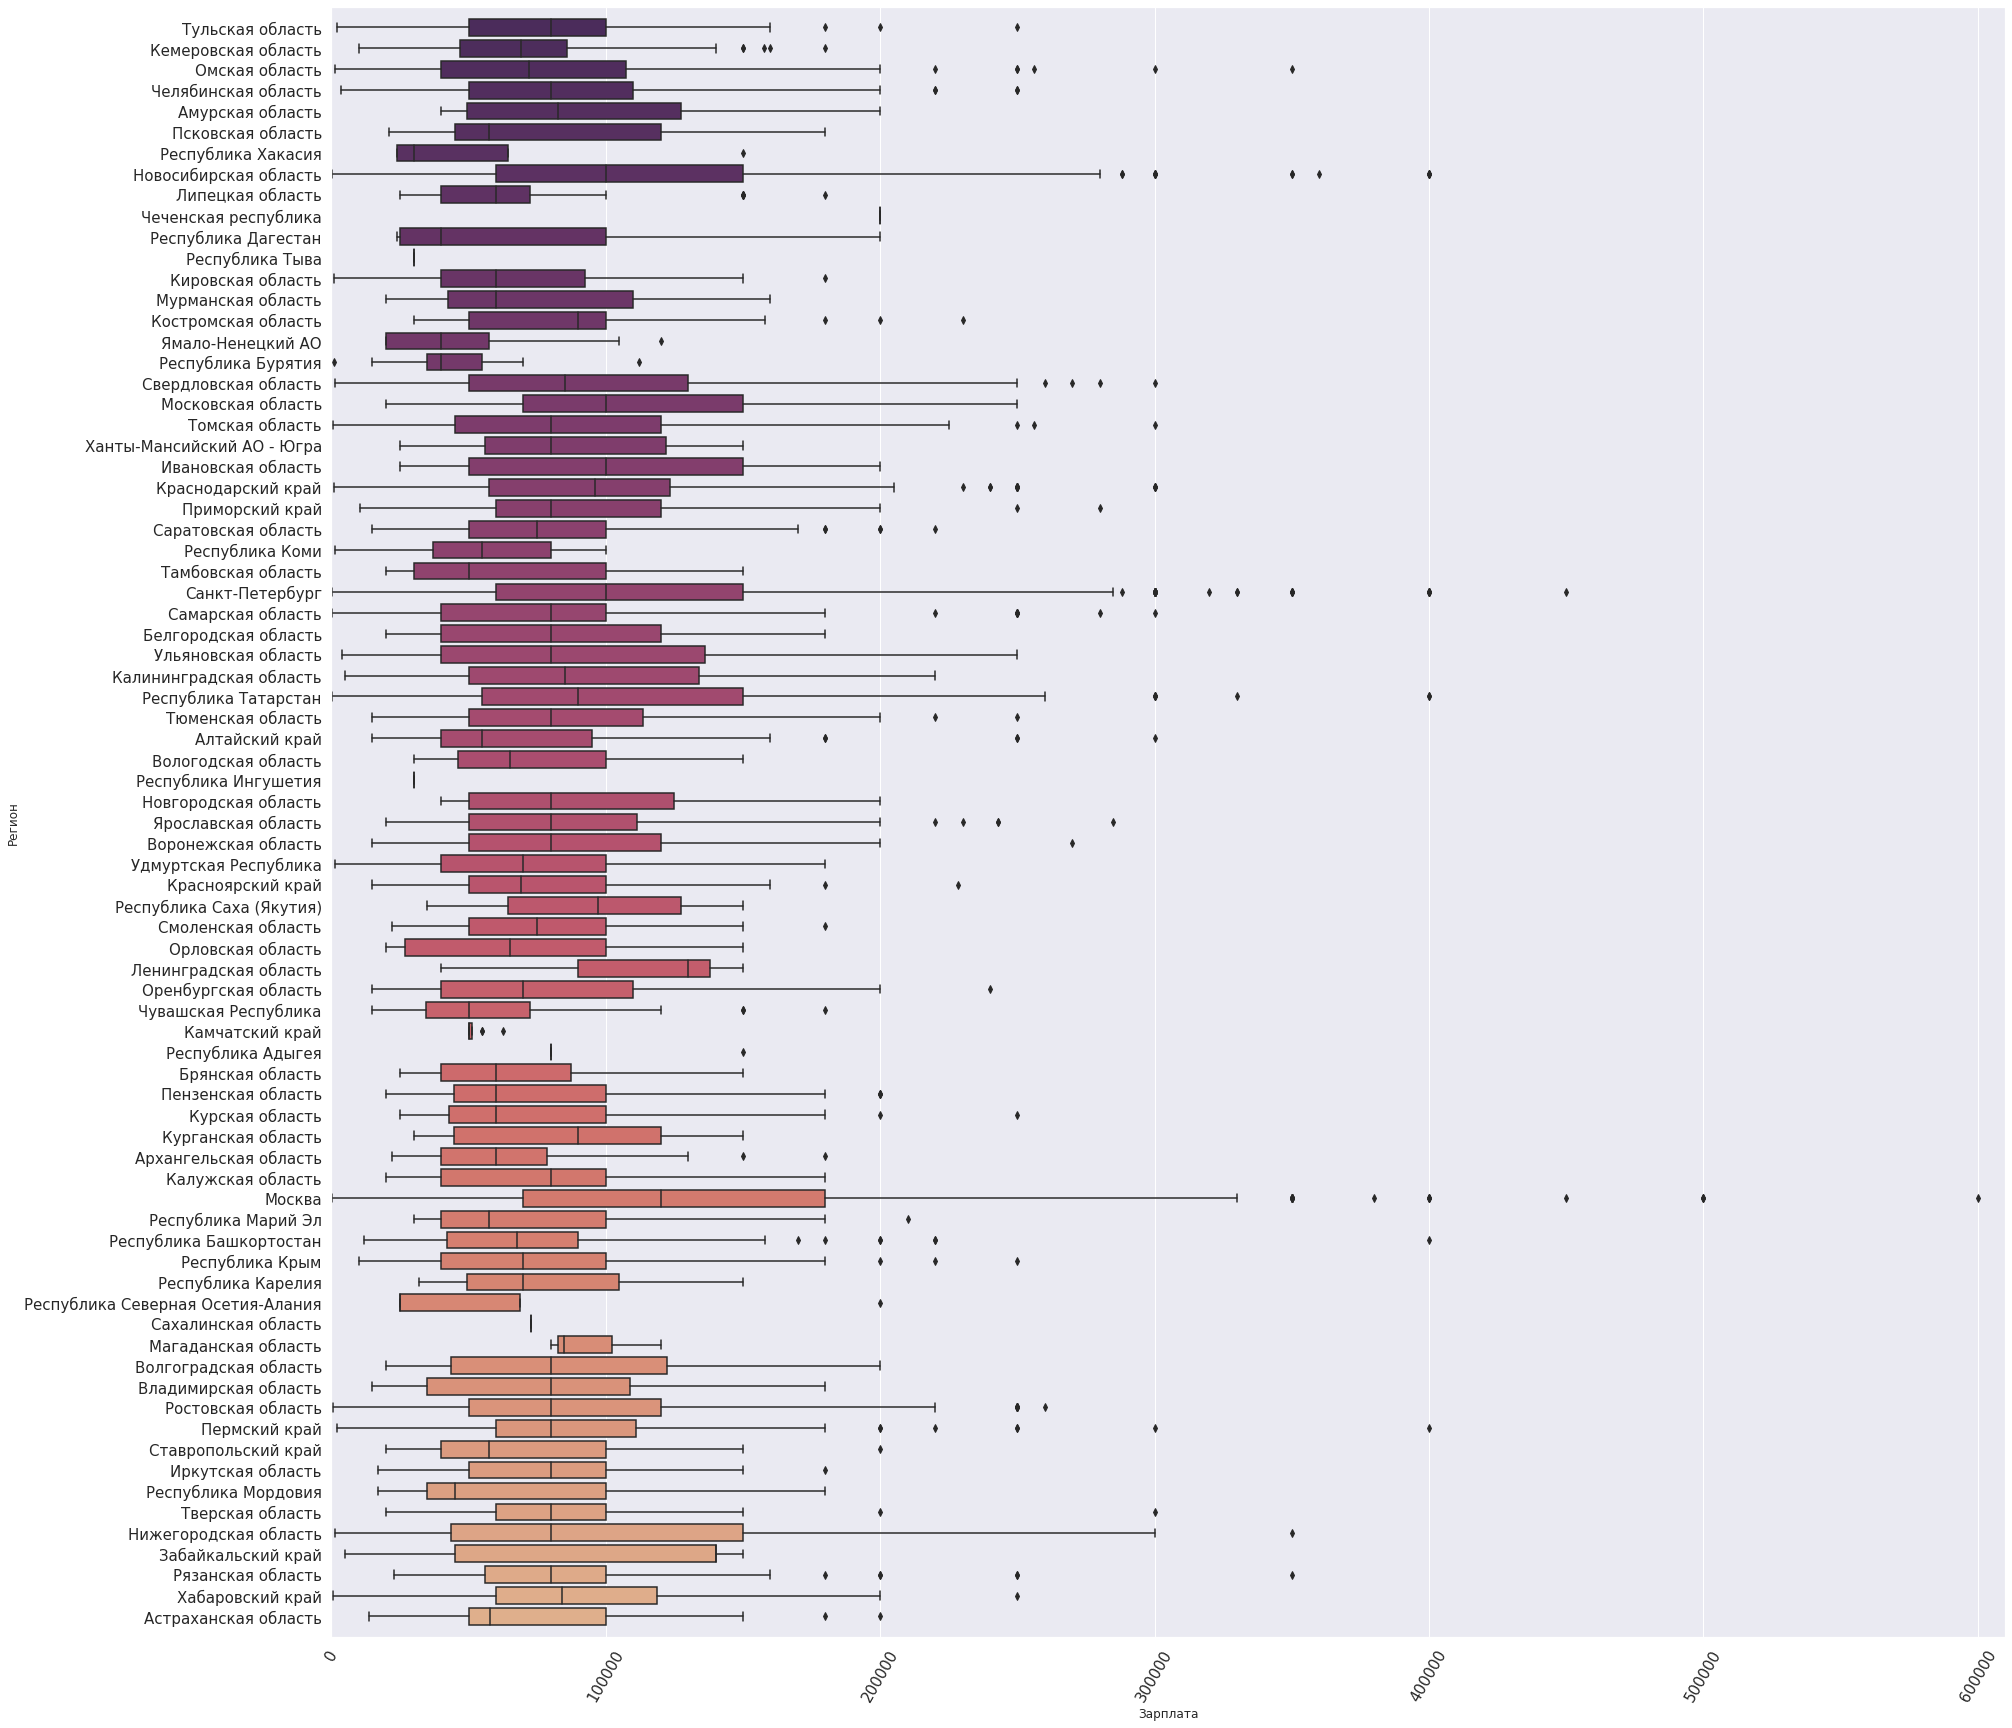

In [ ]:
f, ax = plt.subplots(figsize=(30, 30))
fig = sns.boxplot(x='Зарплата', y='Регион', data=df, palette='flare')
plt.xticks(fontsize = 15, rotation = 60)
plt.yticks(fontsize = 15)
plt.xlim(0,610000)
plt.ylim(-1, 77)

# ***4. Проверка нормальности распределения данных***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389 entries, 0 to 8388
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Вакансии       8389 non-null   object
 1   Зарплата       8389 non-null   Int64 
 2   Опыт работы    8389 non-null   object
 3   Навыки         8389 non-null   object
 4   Специализация  8389 non-null   object
 5   Регион         8389 non-null   object
dtypes: Int64(1), object(5)
memory usage: 401.6+ KB


## ***Гипотеза 1 - Проверка H0 нормального распределения для зарплаты***

***Распределение уровня зп к количеству вакансий*** 

(0.0, 1100.0)

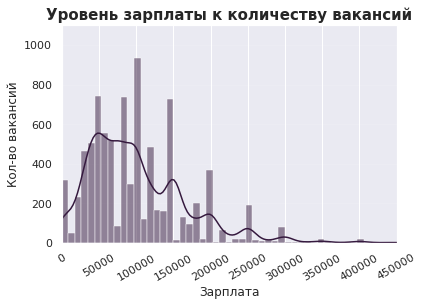

In [ ]:
sns.histplot(data=df['Зарплата'], x=df['Зарплата'], palette='rocket', kde=True)
plt.xticks(rotation=30)
plt.ylabel('Кол-во вакансий')
plt.title('Уровень зарплаты к количеству вакансий',fontweight="bold",fontsize=15)
plt.xlabel('Зарплата')
plt.grid(axis='y', alpha=0.1)
plt.xlim(0, 450000)
plt.ylim(0, 1100)

*Из данного графика видно, что большая часть смещена влево, что говорит нам о неравномерности рапределения уровня зарплат.*

***Проверим гипотезу 1 при помощи критерия Шапиро-Уилка***

In [ ]:
stats.shapiro(df['Зарплата'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9195077419281006, pvalue=0.0)

*H0 отклонена, распределение уровня зарплат не подчинено нормальному закону распределения.*

## *Используем критерий асимметрии и эксцесса для проверки гипотезы 1*

In [ ]:
df['Зарплата'].skew() # коэффициент асимметрии

1.234581709283044

*При нормальном распределении выборки коэффициент асимметрии равен 0, в нашем случае данный критерий говорит о не нормальном распределении уровня заработной платы*

In [ ]:
df['Зарплата'].kurtosis() # коэффициент эксцесса

2.4814652919382842

*Коэффициент эксцесса так же подтверждает что наша выборка не имеет нормального распределения, т.к. при нормальном распределении выборки данный коэффициент равен 3*

## *Гипотеза 2 - Проверка Н0 - уровень дохода не меняется с опытом работы*

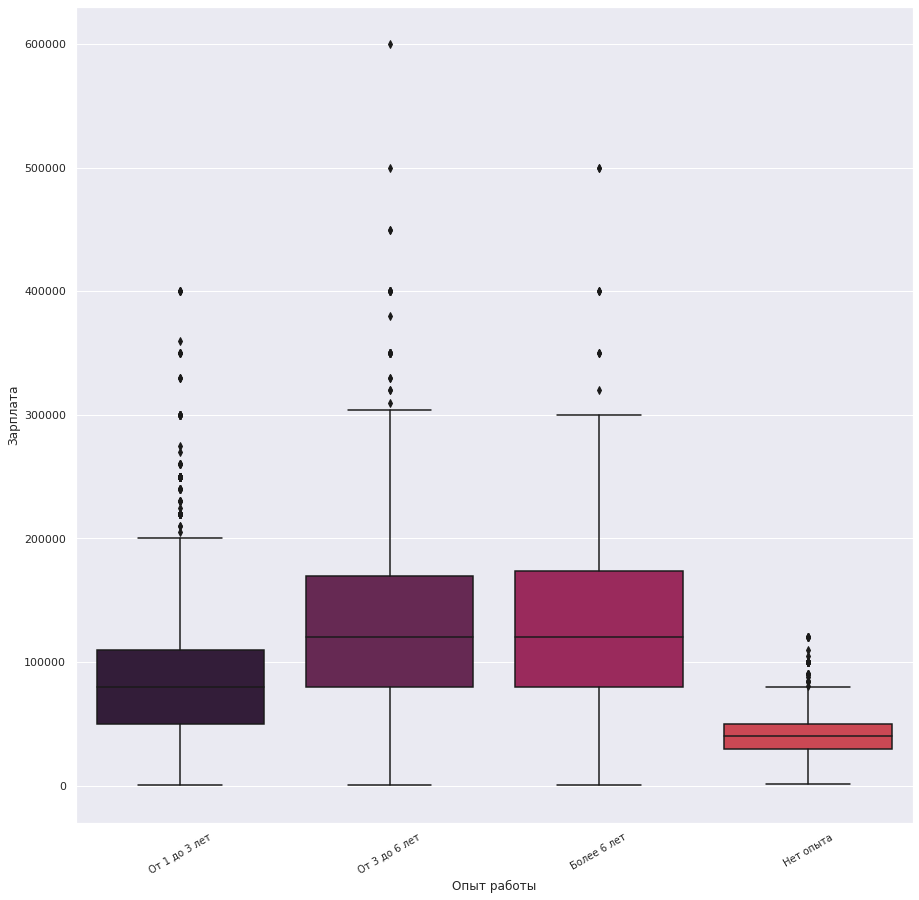

In [ ]:
df1 = df.drop(df.loc[(df['Опыт работы'] == 'Нет опыта') & (df['Зарплата'] > 120000)].index)
f, ax = plt.subplots(figsize=(15, 15))
fig = sns.boxplot(x='Опыт работы', y='Зарплата', data=df1)
plt.xticks(fontsize = 10, rotation = 30) # поворот подписи на 90 градусов
plt.show()

*Т.к. зарплата является количественным типом, а специализация порядковыми, и мы их проверили  на нормальность (распредление обоих не нормальное), то используем тест Краскела-Уоллиса*

In [ ]:
dfd1=np.array(df[df['Опыт работы']=='Нет опыта']['Зарплата'])
dfd2=np.array(df[df['Опыт работы']=='От 1 до 3 лет']['Зарплата'])
dfd3=np.array(df[df['Опыт работы']=='От 3 до 6 лет']['Зарплата'])
dfd4=np.array(df[df['Опыт работы']=='Более 6 лет']['Зарплата'])
stats.mstats.kruskalwallis(dfd1,dfd2,dfd3,dfd4)

KruskalResult(statistic=1562.7538734943669, pvalue=0.0)

*H0 отклонена, средний уровень зарплаты изменяется с получением опыта*

## ***График распределения уровня зарплаты к требуемым навыкам***

In [ ]:
key_skill = [i for i in df['Навыки'].explode().value_counts()[:10].index]

def key_skills(skill):
  try:
      cnt = 0
      for i in range(len(key_skill)):
        if key_skill[i] in skill:
          return key_skill[i]
  except:
    return 0

df['Навыки'] = df['Навыки'].apply(key_skills)
df = df.dropna()

(0.0, 500000.0)

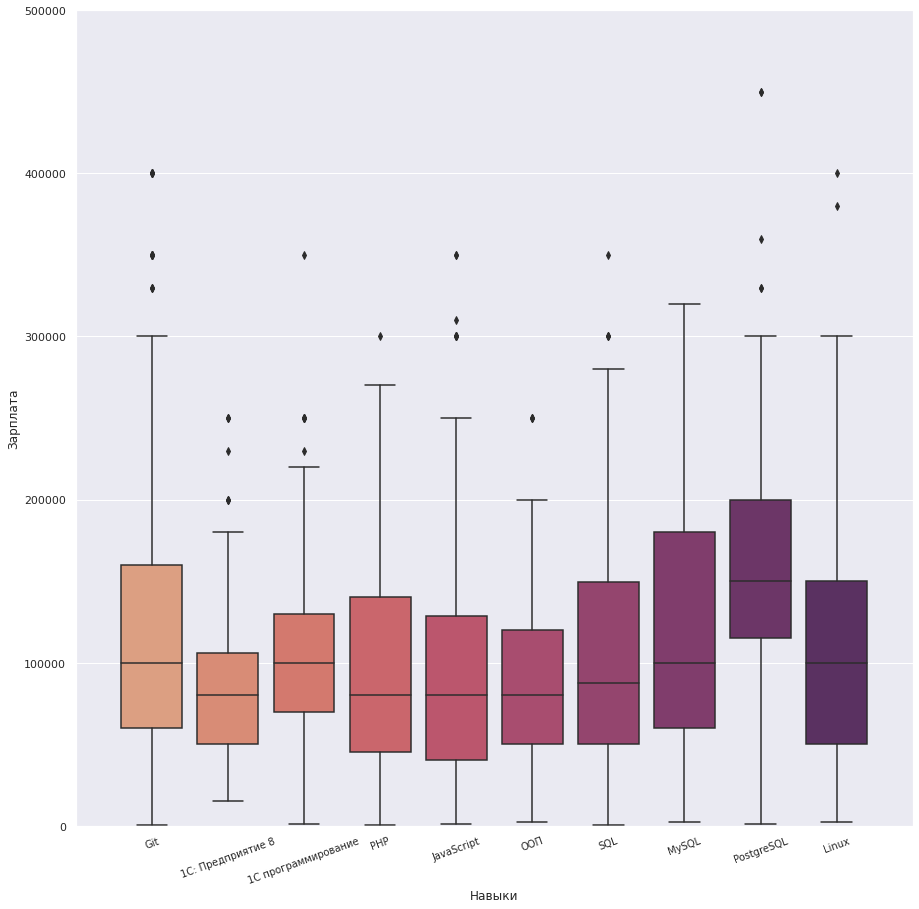

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
fig = sns.boxplot(y='Зарплата', x='Навыки', data=df, palette='flare')
plt.xticks(fontsize = 10, rotation = 20)
plt.xlim(-1,10)
plt.ylim(0,500000)

## *Таблица сопряженности*

In [ ]:
wd=pd.crosstab(df['Опыт работы'],df['Навыки']); wd

Навыки,1С программирование,1С: Предприятие 8,Git,JavaScript,Linux,MySQL,PHP,PostgreSQL,SQL,ООП
Опыт работы,,,,,,,,,,
Более 6 лет,37,3,48,6,5,2,0,4,31,0
Нет опыта,76,18,102,56,10,2,23,2,48,12
От 1 до 3 лет,687,96,891,329,56,18,112,49,256,77
От 3 до 6 лет,455,63,553,151,34,19,60,73,139,35


In [ ]:
chi2, prob, df, expected = scipy.stats.chi2_contingency(wd)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
 
print(output.format( chi2, df, prob))

test Statistics: 116.46037537789175
degrees of freedom: 27
p-value: 4.4122290142141913e-13



*Исходя из таблицы сопряженности, можно сделать вывод что некоторые навыки растут с увеличением роста опыта.*

# ***Выводы:***

## ***Гипотеза 1.***
*Из графика видно явное отсутсвие нормального рапределения уровня зарплат, что подтвержадется критерием Шапиро-Уилка*

## ***Гипотеза 2.***
*Из всего выше проделанного видно, что средний уровень дохода меняется с получением большего опыта работы, это подтверждается тестом Краскела-Уоллиса и графиком построенным на основе двух критериев.*